In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats


from datetime import datetime
from scipy import optimize
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.special import gamma, kv, logsumexp
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from joblib import Parallel, delayed  

import warnings
warnings.filterwarnings('ignore')


from typing import Dict, List, Callable, Any



# Part1 & Part2

In [2]:
class ExPostAttribution:
    def __init__(self, attribution, weights, factor_weights, resid_individual, resid_return, carino_k):
        self.attribution = attribution
        self.weights = weights
        self.factor_weights = factor_weights
        self.resid_individual = resid_individual
        self.resid_return = resid_return
        self.carino_k = carino_k
    
    def __str__(self):
        return str(self.attribution)

def expost_factor(w, up_returns, up_ff_data, betas):
    """
    Compute the ex-post factor attribution for a portfolio
    
    Parameters:
    w: initial weights vector (1D array)
    up_returns: DataFrame of returns for stocks
    up_ff_data: DataFrame of factor returns
    betas: Factor exposures vector (1D array)
    """
    _up_ff_data = up_ff_data.copy()
    stocks = up_returns.columns.tolist()
    factors = up_ff_data.columns.tolist()
    
    n = len(up_returns)
    m = len(stocks)
    
    p_return = np.zeros(n)
    resid_return = np.zeros(n)
    weights = np.zeros((n, len(w)))
    factor_weights = np.zeros((n, len(factors)))
    last_w = w.copy()
    
    mat_returns = up_returns[stocks].values
    ff_returns = up_ff_data[factors].values
    
    # Calculate residual individual returns (ensure correct broadcasting)
    # Each stock's return minus its beta times the factor return
    resid_individual = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            resid_individual[i, j] = mat_returns[i, j] - betas[j] * ff_returns[i, 0]
    
    for i in range(n):
        # Save current weights in matrix
        weights[i, :] = last_w
        
        # Factor weight - for each factor, sum of beta * weight across stocks
        for f in range(len(factors)):
            factor_weights[i, f] = np.sum(betas * last_w)
        
        # Update weights by return
        last_w = last_w * (1.0 + mat_returns[i, :])
        
        # Portfolio return is the sum of the updated weights
        p_r = np.sum(last_w)
        
        # Normalize the weights back so sum = 1
        last_w = last_w / p_r
        
        # Store the return
        p_return[i] = p_r - 1
        
        # Residual
        resid_return[i] = (p_r - 1) - np.dot(factor_weights[i, :], ff_returns[i, :])
    
    # Set the portfolio return in the update return DataFrame
    _up_ff_data['Alpha'] = resid_return
    _up_ff_data['Portfolio'] = p_return
    
    # Calculate the total return
    total_ret = np.exp(np.sum(np.log(p_return + 1))) - 1
    
    # Calculate the Carino K
    k = np.log(total_ret + 1) / total_ret if total_ret != 0 else 1.0
    
    # Carino k_t is the ratio scaled by 1/K
    carino_k = np.zeros_like(p_return)
    for i in range(len(p_return)):
        if p_return[i] != 0:
            carino_k[i] = np.log(1.0 + p_return[i]) / p_return[i] / k
        else:
            carino_k[i] = 1.0 / k
    
    # Calculate the return attribution
    attrib = pd.DataFrame(ff_returns * factor_weights * carino_k.reshape(-1, 1), columns=factors)
    attrib['Alpha'] = resid_return * carino_k
    
    # Update residual individual by weights
    for i in range(n):
        for j in range(m):
            resid_individual[i, j] *= weights[i, j]
    
    # Set up a DataFrame for output
    attribution = pd.DataFrame({'Value': ['TotalReturn', 'Return Attribution']})
    
    new_factors = factors + ['Alpha']
    
    # Loop over the factors
    for s in new_factors + ['Portfolio']:
        # Total stock return over the period
        tr = np.exp(np.sum(np.log(_up_ff_data[s] + 1))) - 1
        # Attribution Return (total portfolio return if we are updating the portfolio column)
        atr = tr if s == 'Portfolio' else np.sum(attrib[s])
        # Set the values
        attribution[s] = [tr, atr]
    
    # Realized Volatility Attribution
    
    # Y is our stock returns scaled by their weight at each time
    Y = np.hstack((ff_returns * factor_weights, resid_return.reshape(-1, 1)))
    
    # Set up X with the Portfolio Return
    X = np.column_stack((np.ones(len(p_return)), p_return))
    
    # Calculate the Beta and discard the intercept
    B = np.linalg.inv(X.T @ X) @ X.T @ Y
    B = B[1, :]
    
    # Component SD is Beta times the standard deviation of the portfolio
    cSD = B * np.std(p_return)
    
    # Check that the sum of component SD is equal to the portfolio SD
    # sum(cSD) should approximately equal np.std(p_return)
    
    # Add the Vol attribution to the output
    vol_attrib = pd.DataFrame({'Value': ['Vol Attribution']})
    portfolio_vol = 0
    for i, factor in enumerate(new_factors):
        portfolio_vol += cSD[i]
        vol_attrib[factor] = [cSD[i]]
    vol_attrib['Portfolio'] = [portfolio_vol]
    
    attribution = pd.concat([attribution, vol_attrib], ignore_index=True)
    
    return ExPostAttribution(
        attribution,
        weights,
        factor_weights,
        resid_individual,
        resid_return,
        carino_k
    )

def return_calculate(prices, method="DISCRETE", date_column="Date"):
    """
    Calculate returns from prices
    
    Parameters:
    prices: DataFrame of prices
    method: "DISCRETE" or "LOG"
    date_column: name of the date column
    """
    vars = prices.columns.tolist()
    vars = [v for v in vars if v != date_column]
    
    if len(vars) == 0:
        raise ValueError(f"dateColumn: {date_column} not in DataFrame: {prices.columns}")
    
    p = prices[vars].values
    n = p.shape[0]
    m = p.shape[1]
    p2 = np.zeros((n-1, m))
    
    for i in range(n-1):
        for j in range(m):
            p2[i, j] = p[i+1, j] / p[i, j]
    
    if method.upper() == "DISCRETE":
        p2 = p2 - 1.0
    elif method.upper() == "LOG":
        p2 = np.log(p2)
    else:
        raise ValueError(f"method: {method} must be in (\"LOG\",\"DISCRETE\")")
    
    dates = prices[date_column].iloc[1:n].reset_index(drop=True)
    out = pd.DataFrame({date_column: dates})
    
    for i, var in enumerate(vars):
        out[var] = p2[:, i]
    
    return out

def OLS(X, Y):
    """
    Ordinary Least Squares regression
    """
    n = len(X)
    X_with_constant = np.column_stack((np.ones(n), X))
    b = np.linalg.inv(X_with_constant.T @ X_with_constant) @ (X_with_constant.T @ Y)
    return b

def run_attribution(realized_returns, realized_spy, last_date, start_prices, portfolio, betas, portfolio_type="Initial"):
    """
    Run the attribution analysis
    
    Parameters:
    realized_returns: DataFrame of realized returns for stocks
    realized_spy: DataFrame of realized returns for SPY
    last_date: last date before the holding period
    start_prices: DataFrame of prices at the start of the holding period
    portfolio: DataFrame of portfolio holdings
    betas: Array of betas for each stock in the portfolio
    portfolio_type: String indicating the type of portfolio for reporting
    """
    # Extract the stocks in order
    stocks = portfolio['Symbol'].tolist()
    
    # Calculate total portfolio value and initial weights
    holdings = portfolio['Holding'].values
    start_price_values = start_prices.values[0]  # Get the values from the DataFrame
    
    t_value = np.sum(start_price_values * holdings)
    w = (start_price_values * holdings) / t_value
    
    attrib = expost_factor(w, realized_returns, realized_spy, betas)
    print(f"\n{portfolio_type} Total Portfolio Attribution")
    print(attrib.attribution)
    
    # Track attribution results for each portfolio
    all_results = {
        'Total': attrib.attribution
    }
    
    portfolios = sorted(list(set(portfolio['Portfolio'])))
    for p in portfolios:
        # Filter stocks in this portfolio
        stocks_mask = portfolio['Portfolio'] == p
        p_stocks = portfolio.loc[stocks_mask, 'Symbol'].tolist()
        
        # Get stock returns and prices for this portfolio
        stock_returns = realized_returns[p_stocks]
        p_start_prices = start_prices[p_stocks].values[0]
        
        # Get holdings for these stocks
        p_holdings = portfolio.loc[stocks_mask, 'Holding'].values
        
        # Calculate weights
        p_t_value = np.sum(p_start_prices * p_holdings)
        p_w = (p_start_prices * p_holdings) / p_t_value
        
        # Get betas for these stocks
        p_betas = np.array([betas[stocks.index(s)] for s in p_stocks])
        
        # Run attribution analysis
        p_attrib = expost_factor(p_w, stock_returns, realized_spy, p_betas)
        print(f"{portfolio_type} {p} Portfolio Attribution")
        print(p_attrib.attribution, '\n')
        
        all_results[p] = p_attrib.attribution
    
    return all_results

def calculate_expected_returns(betas, avg_mkt_return, avg_rf):
    """
    Calculate expected returns using CAPM
    
    Parameters:
    betas: Array of betas for each stock
    avg_mkt_return: Average market return
    avg_rf: Average risk-free rate
    
    Returns:
    Array of expected returns for each stock
    """
    return avg_rf + betas * (avg_mkt_return - avg_rf)

def calculate_covariance_matrix(returns, betas, market_returns):
    """
    Calculate covariance matrix using single-factor model
    
    Parameters:
    returns: DataFrame of stock returns
    betas: Array of betas for each stock
    market_returns: Series of market returns
    
    Returns:
    Covariance matrix
    """
    n = len(betas)
    market_var = np.var(market_returns)
    
    # Calculate residual returns
    resid = np.zeros((len(returns), n))
    for i in range(n):
        resid[:, i] = returns.iloc[:, i] - betas[i] * market_returns
    
    # Calculate residual variances
    resid_var = np.var(resid, axis=0)
    
    # Initialize covariance matrix
    cov_matrix = np.zeros((n, n))
    
    # Fill the covariance matrix
    for i in range(n):
        for j in range(n):
            if i == j:
                # Diagonal elements: total variance
                cov_matrix[i, j] = betas[i]**2 * market_var + resid_var[i]
            else:
                # Off-diagonal elements: systematic component only
                cov_matrix[i, j] = betas[i] * betas[j] * market_var
    
    return cov_matrix

def optimize_sharpe_ratio(exp_returns, cov_matrix, rf_rate):
    """
    Find the weights that maximize the Sharpe ratio
    
    Parameters:
    exp_returns: Array of expected returns for each stock
    cov_matrix: Covariance matrix of stock returns
    rf_rate: Risk-free rate
    
    Returns:
    Array of optimal weights
    """
    n = len(exp_returns)
    
    def negative_sharpe(weights):
        portfolio_return = np.sum(weights * exp_returns)
        portfolio_stddev = np.sqrt(weights.T @ cov_matrix @ weights)
        return -(portfolio_return - rf_rate) / portfolio_stddev
    
    # Constraint: sum of weights = 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
    # Bounds: all weights between 0 and 1 (long-only)
    bounds = tuple((0, 1) for _ in range(n))
    
    # Initial guess: equal weights
    initial_weights = np.ones(n) / n
    
    # Run optimization
    result = minimize(negative_sharpe, initial_weights, method='SLSQP', 
                       bounds=bounds, constraints=constraints, options={'disp': False})
    
    return result.x

def create_optimal_portfolios(portfolio, betas, all_returns, to_fit, avg_rf):
    """
    Create optimal portfolios based on maximum Sharpe ratio
    
    Parameters:
    portfolio: DataFrame of portfolio holdings
    betas: Array of betas for each stock
    all_returns: DataFrame of all returns
    to_fit: DataFrame of returns used for fitting
    avg_rf: Average risk-free rate
    
    Returns:
    DataFrame of optimal portfolio holdings
    """
    # Create a copy of the portfolio DataFrame to modify
    optimal_portfolio = portfolio.copy()
    
    # Calculate average market return
    avg_mkt_return = to_fit['SPY'].mean()

    # Get unique portfolios
    portfolios = sorted(list(set(portfolio['Portfolio'])))
    
    for p in portfolios:
        # Filter stocks in this portfolio
        stocks_mask = portfolio['Portfolio'] == p
        p_stocks = portfolio.loc[stocks_mask, 'Symbol'].tolist()
        
        # Get betas for these stocks
        p_betas = np.array([betas[portfolio['Symbol'].tolist().index(s)] for s in p_stocks])
        
        # Calculate expected returns
        exp_returns = calculate_expected_returns(p_betas, avg_mkt_return, avg_rf)
        
        # Calculate covariance matrix
        p_returns = to_fit[p_stocks]
        cov_matrix = calculate_covariance_matrix(p_returns, p_betas, to_fit['SPY'])
        
        # Find optimal weights
        optimal_weights = optimize_sharpe_ratio(exp_returns, cov_matrix, avg_rf)
        
        # Calculate total value of this portfolio
        p_holdings = portfolio.loc[stocks_mask, 'Holding'].values
        p_prices = all_returns[all_returns['Date'] < datetime(2024, 1, 1)]['Date'].max()
        
        # Normalize weights to maintain the same total portfolio value
        # We'll set the total value to 1000 shares for simplicity
        total_shares = 1000
        optimal_holdings = optimal_weights * total_shares
        
        # Update holdings in the optimal portfolio DataFrame
        for i, stock in enumerate(p_stocks):
            optimal_portfolio.loc[optimal_portfolio['Symbol'] == stock, 'Holding'] = optimal_holdings[i]
    
    return optimal_portfolio

def analyze_results(initial_results, optimal_results):
    """
    Analyze and compare the results of initial and optimal portfolios
    
    Parameters:
    initial_results: Dictionary of attribution results for initial portfolios
    optimal_results: Dictionary of attribution results for optimal portfolios
    """
    print("\n==== PERFORMANCE COMPARISON: INITIAL VS OPTIMAL PORTFOLIOS ====")
    
    # Compare total portfolio return
    initial_total_return = initial_results['Total'].loc[0, 'Portfolio']
    optimal_total_return = optimal_results['Total'].loc[0, 'Portfolio']
    
    print(f"Total Portfolio Return: Initial {initial_total_return:.4f} vs Optimal {optimal_total_return:.4f}")
    print(f"Improvement: {optimal_total_return - initial_total_return:.4f} ({(optimal_total_return - initial_total_return) / abs(initial_total_return) * 100:.2f}%)")
    
    # Compare systematic vs idiosyncratic contributions
    print("\nSystematic vs Idiosyncratic Attribution:")
    print(f"{'Portfolio':<10} {'Initial Systematic':<20} {'Initial Idiosyncratic':<20} {'Optimal Systematic':<20} {'Optimal Idiosyncratic':<20}")
    
    portfolios = ['Total'] + sorted(list(set(initial_results.keys()) - {'Total'}))
    
    for p in portfolios:
        init_systematic = initial_results[p].loc[1, 'SPY']
        init_idiosyncratic = initial_results[p].loc[1, 'Alpha']
        opt_systematic = optimal_results[p].loc[1, 'SPY']
        opt_idiosyncratic = optimal_results[p].loc[1, 'Alpha']
        
        print(f"{p:<10} {init_systematic:<20.4f} {init_idiosyncratic:<20.4f} {opt_systematic:<20.4f} {opt_idiosyncratic:<20.4f}")
    
    # Compare volatility attribution
    print("\nVolatility Attribution:")
    print(f"{'Portfolio':<10} {'Initial Systematic':<20} {'Initial Idiosyncratic':<20} {'Optimal Systematic':<20} {'Optimal Idiosyncratic':<20}")
    
    for p in portfolios:
        init_systematic_vol = initial_results[p].loc[2, 'SPY']
        init_idiosyncratic_vol = initial_results[p].loc[2, 'Alpha']
        opt_systematic_vol = optimal_results[p].loc[2, 'SPY']
        opt_idiosyncratic_vol = optimal_results[p].loc[2, 'Alpha']
        
        print(f"{p:<10} {init_systematic_vol:<20.4f} {init_idiosyncratic_vol:<20.4f} {opt_systematic_vol:<20.4f} {opt_idiosyncratic_vol:<20.4f}")


In [3]:
# Read in the Data
portfolio = pd.read_csv("initial_portfolio.csv")
rf = pd.read_csv("rf.csv")
prices = pd.read_csv("DailyPrices.csv")

# Convert date columns to datetime
prices['Date'] = pd.to_datetime(prices['Date'])
rf['Date'] = pd.to_datetime(rf['Date'])

# Calculate returns
all_returns = return_calculate(prices, method="DISCRETE", date_column="Date")
all_returns = pd.merge(all_returns, rf, on='Date', how='left')

stocks = portfolio['Symbol'].tolist()
n_stocks = len(stocks)

# Fit the CAPM Model
betas = np.zeros(n_stocks)

# Filter data to before end of 2023
to_fit = all_returns[all_returns['Date'] < datetime(2023, 12, 31)]

# Calculate average risk-free rate
avg_rf = to_fit['rf'].mean()

for i, s in enumerate(stocks):
    betas[i] = OLS(to_fit['SPY'] - to_fit['rf'], to_fit[s] - to_fit['rf'])[1]

capm_betas = pd.DataFrame({'Symbol': stocks, 'Beta': betas})
# print("CAPM Betas:")
# print(capm_betas)


# Get realized returns from 2024 onwards
realized_returns = all_returns[all_returns['Date'] >= datetime(2024, 1, 1)][stocks]
realized_spy = pd.DataFrame({'SPY': all_returns[all_returns['Date'] >= datetime(2024, 1, 1)]['SPY']})

# Get prices at the end of 2023
last_date = all_returns[all_returns['Date'] < datetime(2024, 1, 1)]['Date'].max()
start_prices = prices[prices['Date'] == last_date][stocks]

print("\n==== PART 1: ATTRIBUTION ANALYSIS WITH INITIAL PORTFOLIOS ====")
# Run the attribution analysis for initial portfolios
initial_results = run_attribution(realized_returns, realized_spy, last_date, start_prices, portfolio, betas, "Initial")



==== PART 1: ATTRIBUTION ANALYSIS WITH INITIAL PORTFOLIOS ====

Initial Total Portfolio Attribution
                Value       SPY     Alpha  Portfolio
0         TotalReturn  0.261373 -0.035969   0.204731
1  Return Attribution  0.244039 -0.039309   0.204731
2     Vol Attribution  0.007207 -0.000131   0.007076
Initial A Portfolio Attribution
                Value       SPY     Alpha  Portfolio
0         TotalReturn  0.261373 -0.095555   0.136642
1  Return Attribution  0.242621 -0.105980   0.136642
2     Vol Attribution  0.007056  0.000348   0.007404 

Initial B Portfolio Attribution
                Value       SPY     Alpha  Portfolio
0         TotalReturn  0.261373 -0.028626   0.203526
1  Return Attribution  0.234259 -0.030733   0.203526
2     Vol Attribution  0.006411  0.000442   0.006854 

Initial C Portfolio Attribution
                Value       SPY     Alpha  Portfolio
0         TotalReturn  0.261373  0.022337   0.281172
1  Return Attribution  0.255627  0.025546   0.281172
2   

In [4]:
print("\n==== PART 2: OPTIMAL MAXIMUM SHARPE RATIO PORTFOLIOS ====")
# Create optimal portfolios
optimal_portfolio = create_optimal_portfolios(portfolio, betas, all_returns, to_fit, avg_rf)

# Display optimal weights
# print("\nOptimal Portfolio Weights:")
portfolios = sorted(list(set(optimal_portfolio['Portfolio'])))
for p in portfolios:
    p_stocks = optimal_portfolio[optimal_portfolio['Portfolio'] == p]
    total_holding = p_stocks['Holding'].sum()
    p_weights = p_stocks['Holding'] / total_holding
    
    # print(f"\nPortfolio {p} Optimal Weights:")
    # for i, (_, row) in enumerate(p_stocks.iterrows()):
    #     print(f"{row['Symbol']}: {p_weights.iloc[i]:.4f}")

# Run attribution analysis for optimal portfolios
optimal_results = run_attribution(realized_returns, realized_spy, last_date, start_prices, optimal_portfolio, betas, "Optimal")

# Analyze and compare results
analyze_results(initial_results, optimal_results)


==== PART 2: OPTIMAL MAXIMUM SHARPE RATIO PORTFOLIOS ====

Optimal Total Portfolio Attribution
                Value       SPY     Alpha  Portfolio
0         TotalReturn  0.261373 -0.029040   0.241423
1  Return Attribution  0.273015 -0.031591   0.241423
2     Vol Attribution  0.007677  0.000208   0.007886
Optimal A Portfolio Attribution
                Value       SPY     Alpha  Portfolio
0         TotalReturn  0.261373 -0.053660   0.224511
1  Return Attribution  0.284686 -0.060175   0.224511
2     Vol Attribution  0.007845  0.001252   0.009097 

Optimal B Portfolio Attribution
                Value       SPY     Alpha  Portfolio
0         TotalReturn  0.261373 -0.069802   0.186744
1  Return Attribution  0.263700 -0.076955   0.186744
2     Vol Attribution  0.007204  0.000182   0.007386 

Optimal C Portfolio Attribution
                Value       SPY     Alpha  Portfolio
0         TotalReturn  0.261373  0.011513   0.288082
1  Return Attribution  0.274086  0.013996   0.288082
2     Vol

# Part3

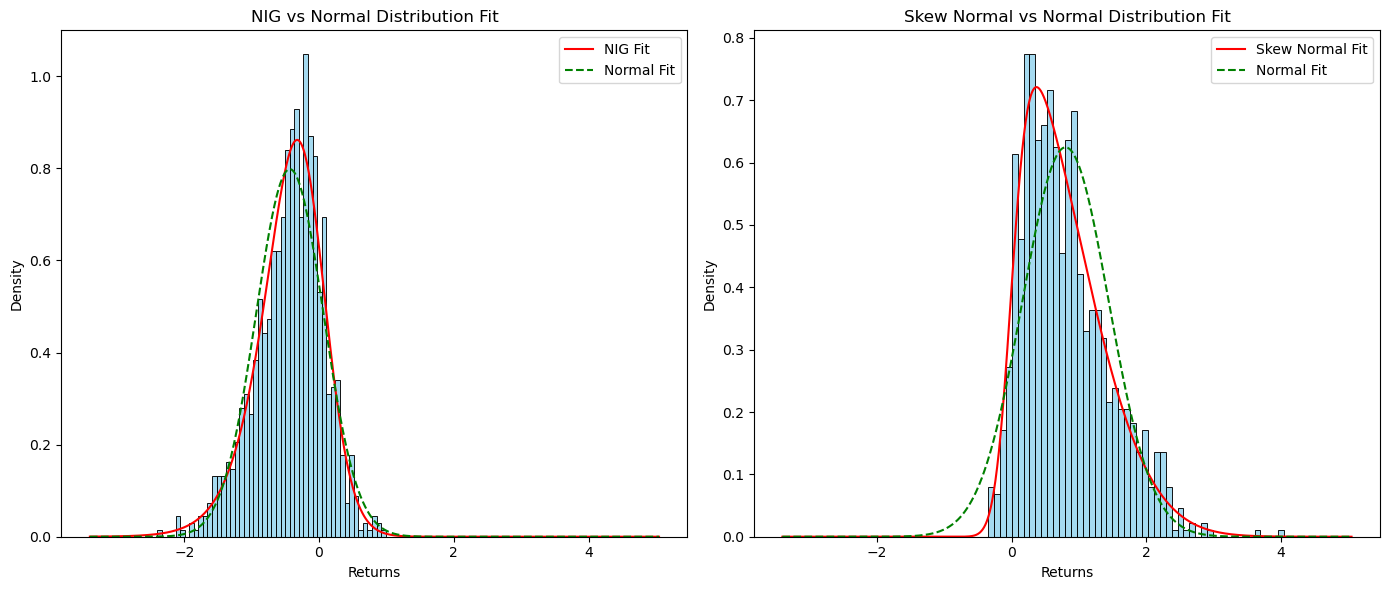

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norminvgauss, skewnorm

# Set random seed for reproducibility
np.random.seed(42)

# Generate sample data for Normal Inverse Gaussian (NIG)
nig_alpha, nig_beta, nig_loc, nig_scale = 5, -2, 0, 1  # parameters chosen to show skewness and kurtosis
data_nig = norminvgauss.rvs(a=nig_alpha, b=nig_beta, loc=nig_loc, scale=nig_scale, size=1000)

# Generate sample data for Skew Normal (SN)
sn_shape, sn_loc, sn_scale = 5, 0, 1  # shape parameter chosen for visible skewness
data_sn = skewnorm.rvs(a=sn_shape, loc=sn_loc, scale=sn_scale, size=1000)


from scipy.stats import norm

# Create a range of x values for plotting PDFs
x = np.linspace(min(data_nig.min(), data_sn.min()) - 1, max(data_nig.max(), data_sn.max()) + 1, 1000)

# Fit Normal distribution parameters
mu_nig, std_nig = norm.fit(data_nig)
mu_sn, std_sn = norm.fit(data_sn)

# Calculate PDFs
pdf_nig = norminvgauss.pdf(x, a=nig_alpha, b=nig_beta, loc=nig_loc, scale=nig_scale)
pdf_sn = skewnorm.pdf(x, a=sn_shape, loc=sn_loc, scale=sn_scale)
pdf_norm_nig = norm.pdf(x, mu_nig, std_nig)
pdf_norm_sn = norm.pdf(x, mu_sn, std_sn)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# NIG vs Normal
sns.histplot(data_nig, bins=50, kde=False, stat='density', ax=axes[0], color='skyblue')
axes[0].plot(x, pdf_nig, label='NIG Fit', color='red')
axes[0].plot(x, pdf_norm_nig, label='Normal Fit', color='green', linestyle='--')
axes[0].set_title('NIG vs Normal Distribution Fit')
axes[0].set_xlabel('Returns')
axes[0].set_ylabel('Density')
axes[0].legend()

# SN vs Normal
sns.histplot(data_sn, bins=50, kde=False, stat='density', ax=axes[1], color='skyblue')
axes[1].plot(x, pdf_sn, label='Skew Normal Fit', color='red')
axes[1].plot(x, pdf_norm_sn, label='Normal Fit', color='green', linestyle='--')
axes[1].set_title('Skew Normal vs Normal Distribution Fit')
axes[1].set_xlabel('Returns')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.show()



# Part4

In [6]:

# Load the data
def load_data():
    # Load stock prices
    prices_df = pd.read_csv('DailyPrices.csv')
    prices_df['Date'] = pd.to_datetime(prices_df['Date'])
    prices_df.set_index('Date', inplace=True)
    
    # Load portfolio holdings
    portfolio_df = pd.read_csv('initial_portfolio.csv')
    
    return prices_df, portfolio_df

# Split data into pre-holding and holding periods
def split_data(prices_df):
    # Split data at 2024-01-01
    pre_holding = prices_df[prices_df.index < '2024-01-01']
    holding = prices_df[prices_df.index >= '2024-01-01']
    
    return pre_holding, holding

# Calculate portfolio weights
def calculate_weights(prices_df, portfolio_df):
    # Get the last trading day of 2023
    last_day_2023 = prices_df[prices_df.index < '2024-01-01'].index.max()
    last_prices = prices_df.loc[last_day_2023]
    
    # Dictionary to store portfolio weights
    portfolio_weights = {}
    
    # Calculate weights for each portfolio
    for portfolio in portfolio_df['Portfolio'].unique():
        portfolio_holdings = portfolio_df[portfolio_df['Portfolio'] == portfolio]
        
        # Calculate the total value of the portfolio
        portfolio_values = {}
        total_value = 0
        
        for _, row in portfolio_holdings.iterrows():
            symbol = row['Symbol']
            holding = row['Holding']
            
            # Skip if the symbol is not in the prices data
            if symbol not in last_prices:
                continue
                
            value = last_prices[symbol] * holding
            portfolio_values[symbol] = value
            total_value += value
        
        # Calculate weights
        weights = {symbol: value / total_value for symbol, value in portfolio_values.items()}
        portfolio_weights[portfolio] = weights
        
    # Calculate total weights across all portfolios
    total_value = 0
    portfolio_values = {}
    for _, row in portfolio_df.iterrows():
        symbol = row['Symbol']
        holding = row['Holding']
        
        # Skip if the symbol is not in the prices data
        if symbol not in last_prices:
            continue
            
        value = last_prices[symbol] * holding
        if symbol in portfolio_values:
            portfolio_values[symbol] += value
        else:
            portfolio_values[symbol] = value
        total_value += value
    
    # Calculate weights
    weights = {symbol: value / total_value for symbol, value in portfolio_values.items()}
    portfolio_weights['Total'] = weights
    
    return portfolio_weights, last_day_2023

# Implementation of Higham's nearest positive definite matrix algorithm
def nearest_pd(A):
    """Find the nearest positive-definite matrix to input A."""
    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)
    
    H = np.dot(V.T, np.dot(np.diag(s), V))
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    
    if is_pd(A3):
        return A3
    
    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    k = 1
    while not is_pd(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1
    
    return A3

def is_pd(A):
    """Returns True if A is positive definite."""
    try:
        np.linalg.cholesky(A)
        return True
    except np.linalg.LinAlgError:
        return False

# Implementation of different distributions
class DistributionFitter:
    def __init__(self):
        self.distributions = {
            'Normal': self.fit_normal,
            'Generalized_T': self.fit_generalized_t,
            'NIG': self.fit_nig,
            'Skew_Normal': self.fit_skew_normal
        }
        self.fallback_flags = {}  # To track which distributions used fallback
        
    def fit_normal(self, data):
        # Fit normal with mean constrained to zero
        sigma = np.std(data, ddof=1)  # Unbiased estimation with ddof=1
        mu = 0  # Fixed at zero as per requirement
        
        n = len(data)
        k = 1  # Only one parameter (sigma) since mu is fixed at 0
        loglik = np.sum(stats.norm.logpdf(data, mu, sigma))
        
        # Calculate AICC: AIC + 2k(k+1)/(n-k-1)
        aic = 2 * k - 2 * loglik
        aicc = aic + (2 * k * (k + 1)) / (n - k - 1) if n > k + 1 else np.inf
        
        return {
            'name': 'Normal',
            'params': {'mu': mu, 'sigma': sigma},
            'aic': aic,
            'aicc': aicc,
            'pdf': lambda x: stats.norm.pdf(x, mu, sigma),
            'cdf': lambda x: stats.norm.cdf(x, mu, sigma),
            'ppf': lambda q: stats.norm.ppf(q, mu, sigma),
            'is_fallback': False
        }
    
    def fit_generalized_t(self, data):
        # Initial parameters: loc, scale, shape1 (nu), shape2 (p)
        def neg_log_likelihood(params):
            # We fix loc=0 and only optimize scale, nu, p
            scale, nu, p = params
            loc = 0  # Fixed at zero
            
            if scale <= 0 or nu <= 0 or p <= 0:
                return np.inf
            
            try:
                nu_pow = nu ** (1/p)  # nu^(1/p)
                p1 = p / (2 * nu_pow * self._beta_func(1/p, nu)) 
                p2 = 1 / scale
                p3 = np.power(1 + (1/nu) * np.power(np.abs(data - loc) / scale, p), -(nu + 1/p))  
                
                # Avoid log(0)
                p3 = np.clip(p3, 1e-10, None)
                loglik = np.log(p1) + np.log(p2) + np.log(p3)
                return -np.sum(loglik)
            except:
                return np.inf
                
        # Initial guesses (without loc as it's fixed to 0)
        initial_guess = [np.std(data, ddof=1), 5.0, 2.0]  # Unbiased estimation with ddof=1
        
        try:
            result = minimize(neg_log_likelihood, initial_guess, 
                             bounds=[(1e-6, np.inf), (1e-6, np.inf), (1e-6, np.inf)],
                             method='L-BFGS-B')
            
            scale, nu, p = result.x
            loc = 0  # Fixed at zero
            
            n = len(data)
            k = 3  # Number of parameters: scale, nu, p (loc is fixed)
            loglik = -neg_log_likelihood(result.x)
            
            # AIC = 2k - 2ln(L)
            aic = 2 * k - 2 * loglik
            # AICC = AIC + 2k(k+1)/(n-k-1)
            aicc = aic + (2 * k * (k + 1)) / (n - k - 1) if n > k + 1 else np.inf
            
            # Pre-compute some values for efficiency
            grid_size = 1000
            x_grid = np.linspace(-10*scale + loc, 10*scale + loc, grid_size)
            pdf_grid = np.zeros(grid_size)
            
            for i in range(grid_size):
                pdf_grid[i] = self._gen_t_pdf(x_grid[i], loc, scale, nu, p)
                
            # Compute CDF grid using cumulative trapezoidal integration
            cdf_grid = np.zeros(grid_size)
            for i in range(1, grid_size):
                cdf_grid[i] = cdf_grid[i-1] + 0.5 * (pdf_grid[i] + pdf_grid[i-1]) * (x_grid[i] - x_grid[i-1])
                
            # Normalize CDF to ensure it ends at 1.0
            if cdf_grid[-1] > 0:
                cdf_grid = cdf_grid / cdf_grid[-1]
            
            # Create interpolation functions for faster lookups
            cdf_interp = lambda x: np.interp(x, x_grid, cdf_grid)
            ppf_interp = lambda q: np.interp(q, cdf_grid, x_grid)
            
            # Create the functions using the fitted parameters
            return {
                'name': 'Generalized_T',
                'params': {'loc': loc, 'scale': scale, 'nu': nu, 'p': p},
                'aic': aic,
                'aicc': aicc,
                'pdf': lambda x: self._gen_t_pdf(x, loc, scale, nu, p),
                'cdf': cdf_interp,
                'ppf': ppf_interp,
                'is_fallback': False
            }
        except Exception as e:
            # If optimization fails, return normal distribution as fallback
            print(f"Generalized T fitting failed: {str(e)}")
            normal_fit = self.fit_normal(data)
            normal_fit['is_fallback'] = True
            return normal_fit
    
    def _beta_func(self, a, b):
        # Safe implementation of beta function
        try:
            return gamma(a) * gamma(b) / gamma(a + b)
        except:
            return np.inf
    

    def _gen_t_pdf(self, x, loc, scale, nu, p):
        try:

            nu_pow = nu ** (1/p)  # nu^(1/p)
            p1 = p / (2 * nu_pow * self._beta_func(1/p, nu))  
            p2 = 1 / scale
            p3 = np.power(1 + (1/nu) * np.power(np.abs(x - loc) / scale, p), -(nu + 1/p))  
            return p1 * p2 * p3
        except:
            # 错误处理保持不变
            if np.isscalar(x):
                return 1e-10
            else:
                return np.ones_like(x) * 1e-10
        
    def fit_nig(self, data):
        # Normal Inverse Gaussian distribution with mean 0
        def nig_loglikelihood(params):
            # We fix mu=0 and only optimize alpha, beta, delta
            alpha, beta, delta = params
            mu = 0  # Fixed at zero
            
            if alpha <= 0 or delta <= 0 or np.abs(beta) >= alpha:
                return np.inf
            
            try:
                gamma_param = np.sqrt(alpha**2 - beta**2)
                
                term1 = np.log(alpha) - np.log(np.pi) + np.log(delta)
                # Calculate terms separately for better numerical stability
                term2 = np.log(kv(1, alpha * np.sqrt(delta**2 + (data - mu)**2)))
                term3 = beta * (data - mu) + delta * gamma_param
                # Add the missing term in the log-likelihood
                term4 = -0.5 * np.log(delta**2 + (data - mu)**2)
                
                # Handle potential NaN values
                log_vals = term1 + term2 + term3 + term4
                return np.sum(np.nan_to_num(log_vals, nan=-np.inf))
            except:
                return np.inf
        
        def neg_nig_loglikelihood(params):
            return -nig_loglikelihood(params)
        
        # Initial guesses
        std = np.std(data, ddof=1)  # Unbiased estimation with ddof=1
        skew = stats.skew(data)
        kurtosis = stats.kurtosis(data)
        
        # Convert moments to NIG parameters (rough estimation)
        gamma_est = np.sqrt(3 * kurtosis / 5) if kurtosis > 0 else 1.0
        gamma_est = max(gamma_est, 1e-3)
        
        alpha_est = gamma_est / std if std > 0 else 1.0
        alpha_est = max(alpha_est, 1e-3)
        
        if skew == 0:
            beta_est = 0
        else:
            beta_denom = np.sqrt(3 * kurtosis - 5 * skew**2)
            beta_est = (skew * alpha_est / beta_denom) if beta_denom > 0 else 0
            
        # Ensure |beta| < alpha
        if abs(beta_est) >= alpha_est:
            beta_est = 0.9 * alpha_est * np.sign(beta_est) if beta_est != 0 else 0
            
        delta_est = 1 / (std * np.sqrt(1 + (skew**2 / 3))) if std > 0 else 1.0
        delta_est = max(delta_est, 1e-3)
        
        initial_guess = [alpha_est, beta_est, delta_est]
        
        # Ensure initial guesses are valid
        if np.isnan(initial_guess).any() or alpha_est <= np.abs(beta_est):
            initial_guess = [1.0, 0.0, std if std > 0 else 1.0]
        
        bounds = [(1e-3, None), (None, None), (1e-3, None)]
        
        try:

            constraints = [
                {'type': 'ineq', 'fun': lambda x: x[0] - np.abs(x[1])}  # alpha >= |beta|
            ]
            result = minimize(
                neg_nig_loglikelihood, 
                initial_guess, 
                bounds=bounds, 
                constraints=constraints,  # 添加约束
                method='SLSQP'  # 支持约束的方法
            )

            
            alpha, beta, delta = result.x
            mu = 0  # Fixed at zero
            
            n = len(data)
            k = 3  # Parameter count: alpha, beta, delta (mu is fixed)
            loglik = nig_loglikelihood(result.x)
            
            # AIC = 2k - 2ln(L)
            aic = 2 * k - 2 * loglik
            # AICC = AIC + 2k(k+1)/(n-k-1)
            aicc = aic + (2 * k * (k + 1)) / (n - k - 1) if n > k + 1 else np.inf
            
            # Pre-compute grid values for faster CDF and PPF
            grid_size = 1000
            x_grid = np.linspace(-10*delta + mu, 10*delta + mu, grid_size)
            pdf_grid = np.zeros(grid_size)
            
            for i in range(grid_size):
                pdf_grid[i] = self._nig_pdf(x_grid[i], alpha, beta, mu, delta)
                
            # Compute CDF grid using cumulative trapezoidal integration
            cdf_grid = np.zeros(grid_size)
            for i in range(1, grid_size):
                cdf_grid[i] = cdf_grid[i-1] + 0.5 * (pdf_grid[i] + pdf_grid[i-1]) * (x_grid[i] - x_grid[i-1])
                
            # Normalize CDF to ensure it ends at 1.0
            if cdf_grid[-1] > 0:
                cdf_grid = cdf_grid / cdf_grid[-1]
            
            # Create interpolation functions for faster lookups
            cdf_interp = lambda x: np.interp(x, x_grid, cdf_grid)
            ppf_interp = lambda q: np.interp(q, cdf_grid, x_grid)
            
            return {
                'name': 'NIG',
                'params': {'alpha': alpha, 'beta': beta, 'mu': mu, 'delta': delta},
                'aic': aic,
                'aicc': aicc,
                'pdf': lambda x: self._nig_pdf(x, alpha, beta, mu, delta),
                'cdf': cdf_interp,
                'ppf': ppf_interp,
                'is_fallback': False
            }
        except Exception as e:
            # If optimization fails, return normal distribution as fallback
            print(f"NIG fitting failed: {str(e)}")
            normal_fit = self.fit_normal(data)
            normal_fit['is_fallback'] = True
            return normal_fit
    
    def _nig_pdf(self, x, alpha, beta, mu, delta):
        try:
            gamma_param = np.sqrt(alpha**2 - beta**2)
            numerator = alpha * delta * kv(1, alpha * np.sqrt(delta**2 + (x - mu)**2))
            numerator *= np.exp(delta * gamma_param + beta * (x - mu))
            denominator = np.pi * np.sqrt(delta**2 + (x - mu)**2)
            
            # Handle potential division by zero or invalid values
            result = numerator / denominator
            
            # Replace NaN or inf values with small value
            if np.isscalar(result):
                if np.isnan(result) or np.isinf(result):
                    return 1e-10
                return result
            else:
                return np.nan_to_num(result, nan=1e-10, posinf=1e-10, neginf=1e-10)
                
        except:
            # Return very small value on error
            if np.isscalar(x):
                return 1e-10
            else:
                return np.ones_like(x) * 1e-10
    
    def fit_skew_normal(self, data):
        # Fit skew normal distribution with mean fixed at 0
        def skew_normal_loglikelihood(params):
            shape, scale = params
            loc = 0  # Fixed at zero
            
            if scale <= 0:
                return np.inf
                
            try:
                loglik = np.sum(stats.skewnorm.logpdf(data, shape, loc, scale))
                return -loglik
            except:
                return np.inf
        
        # Initial guesses
        shape_init = stats.skew(data) * 2  # Rough approximation
        scale_init = np.std(data, ddof=1)  # Unbiased estimation with ddof=1
        
        initial_guess = [shape_init, scale_init]
        bounds = [(None, None), (1e-6, None)]
        
        try:
            result = minimize(skew_normal_loglikelihood, initial_guess, 
                             bounds=bounds, method='L-BFGS-B')
            
            shape, scale = result.x
            loc = 0  # Fixed at zero
            
            n = len(data)
            k = 2  # Parameter count: shape and scale (loc is fixed)
            loglik = -skew_normal_loglikelihood(result.x)
            
            # AIC = 2k - 2ln(L)
            aic = 2 * k - 2 * loglik
            # AICC = AIC + 2k(k+1)/(n-k-1)
            aicc = aic + (2 * k * (k + 1)) / (n - k - 1) if n > k + 1 else np.inf
            
            return {
                'name': 'Skew_Normal',
                'params': {'shape': shape, 'loc': loc, 'scale': scale},
                'aic': aic,
                'aicc': aicc,
                'pdf': lambda x: stats.skewnorm.pdf(x, shape, loc, scale),
                'cdf': lambda x: stats.skewnorm.cdf(x, shape, loc, scale),
                'ppf': lambda q: stats.skewnorm.ppf(q, shape, loc, scale),
                'is_fallback': False
            }
        except Exception as e:
            # If optimization fails, return normal distribution as fallback
            print(f"Skew Normal fitting failed: {str(e)}")
            normal_fit = self.fit_normal(data)
            normal_fit['is_fallback'] = True
            return normal_fit
    
    def fit_best_distribution(self, data, symbol):
        best_fit = None
        best_aicc = np.inf
        
        for name, fit_func in self.distributions.items():
            try:
                dist_fit = fit_func(data)
                if dist_fit['aicc'] < best_aicc:  
                    best_aicc = dist_fit['aicc']
                    best_fit = dist_fit
            except Exception as e:
                print(f"Error fitting {name} distribution for {symbol}: {str(e)}")
                continue
        
        # If no distribution fits well, use normal as fallback
        if best_fit is None:
            best_fit = self.fit_normal(data)
            best_fit['is_fallback'] = True
            self.fallback_flags[symbol] = True
        
        return best_fit

# Parallel function for simulating a single stock's returns
def simulate_stock_returns(u, best_fit, n_scenarios):
    """
    Simulate returns for a single stock using its fitted distribution
    """
    return best_fit['ppf'](u)

# Risk model calculation
def calculate_risk_metrics(pre_holding, portfolio_weights, last_day_2023):
    # Initialize distribution fitter
    dist_fitter = DistributionFitter()
    
    # Dictionary to store best fit models for each stock
    best_fits = {}
    fallback_stocks = []
    
    # Fit distributions to each stock's returns
    print("Fitting distributions to each stock...")
    for symbol in pre_holding.columns:
        data = pre_holding[symbol].dropna().values
        
        if len(data) > 30:  # Ensure enough data points
            print(f"Fitting distributions for {symbol}...")
            best_fit = dist_fitter.fit_best_distribution(data, symbol)  # Pass symbol for error reporting
            best_fits[symbol] = best_fit
            
            if best_fit['is_fallback']:
                fallback_stocks.append(symbol)
    
    if fallback_stocks:
        print("\nWARNING: The following stocks used Normal distribution as fallback due to fitting failures:")
        for symbol in fallback_stocks:
            print(f"  - {symbol}")
    
    # Calculate correlation matrix for Gaussian Copula
    correlation_matrix = pre_holding.corr()
    
    # Ensure correlation matrix is positive definite using Higham's algorithm
    if not is_pd(correlation_matrix.values):
        print("Making correlation matrix positive definite using Higham's algorithm...")
        pd_corr_matrix = nearest_pd(correlation_matrix.values)
        correlation_matrix = pd.DataFrame(
            pd_corr_matrix, 
            index=correlation_matrix.index, 
            columns=correlation_matrix.columns
        )
    
    # Calculate VaR and ES for each portfolio using fitted models and Gaussian Copula
    var_es_results = {}
    
    # Generate large number of scenarios
    n_scenarios = 10000
    np.random.seed(42)
    
    # Generate correlated normal variables using Gaussian Copula
    normal_samples = np.random.multivariate_normal(
        mean=np.zeros(len(correlation_matrix)),
        cov=correlation_matrix.values,
        size=n_scenarios
    )
    uniform_samples = stats.norm.cdf(normal_samples)
    
    # For each portfolio, calculate VaR and ES
    print("\nCalculating VaR and ES for each portfolio...")
    for portfolio, weights in portfolio_weights.items():
        print(f"Processing portfolio: {portfolio}")
        
        # Get the stocks in the portfolio
        stocks = list(weights.keys())
        
        # Filter to only stocks with fitted distributions
        stocks = [s for s in stocks if s in best_fits]
        
        if not stocks:
            print(f"  Warning: No stocks with fitted distributions in portfolio {portfolio}")
            continue
        
        # Generate simulated returns using the fitted distributions
        simulated_returns_fitted = np.zeros((n_scenarios, len(stocks)))
        simulated_returns_normal = np.zeros((n_scenarios, len(stocks)))
        
        # Use parallel processing for the simulation
        results_fitted = []
        
        for i, symbol in enumerate(stocks):
            # For fitted distributions
            u = uniform_samples[:, list(correlation_matrix.columns).index(symbol)]
            
            # Store stock index, its weight, and the uniform samples for parallel processing
            results_fitted.append((i, symbol, u))
            
            # For multivariate normal (simpler, do in-place)
            std = np.std(pre_holding[symbol].dropna(), ddof=1)  # Unbiased estimation with ddof=1
            simulated_returns_normal[:, i] = stats.norm.ppf(u, loc=0, scale=std)
        
        # Process fitted distributions in parallel
        print(f"  Simulating returns for portfolio {portfolio}...")
        
        # Function to process a single stock
        def process_stock(result_tuple):
            i, symbol, u = result_tuple
            return i, simulate_stock_returns(u, best_fits[symbol], len(u))
        
        # Process in parallel
        try:
            parallel_results = Parallel(n_jobs=-1)(
                delayed(process_stock)(res) for res in results_fitted
            )
            
            # Assign results back to the array
            for i, returns in parallel_results:
                simulated_returns_fitted[:, i] = returns
        except Exception as e:
            print(f"Parallel processing failed: {str(e)}. Falling back to sequential processing.")
            # Fallback to sequential processing
            for i, symbol, u in results_fitted:
                simulated_returns_fitted[:, i] = best_fits[symbol]['ppf'](u)
        
        # Calculate portfolio returns
        portfolio_returns_fitted = np.zeros(n_scenarios)
        portfolio_returns_normal = np.zeros(n_scenarios)
        
        for i, symbol in enumerate(stocks):
            weight = weights[symbol]
            portfolio_returns_fitted += weight * simulated_returns_fitted[:, i]
            portfolio_returns_normal += weight * simulated_returns_normal[:, i]
        
        # Calculate 1-day VaR at 95% confidence level
        var_95_fitted = -np.percentile(portfolio_returns_fitted, 5)
        es_95_fitted = -np.mean(portfolio_returns_fitted[portfolio_returns_fitted <= -var_95_fitted])
        
        var_95_normal = -np.percentile(portfolio_returns_normal, 5)
        es_95_normal = -np.mean(portfolio_returns_normal[portfolio_returns_normal <= -var_95_normal])
        
        # Store results
        var_es_results[portfolio] = {
            'Fitted': {
                'VaR_95': var_95_fitted,
                'ES_95': es_95_fitted
            },
            'Normal': {
                'VaR_95': var_95_normal,
                'ES_95': es_95_normal
            }
        }
    
    return best_fits, var_es_results


prices_df, portfolio_df = load_data()
portfolio_weights, last_day_2023 = calculate_weights(prices_df, portfolio_df)
returns_df = prices_df.pct_change().dropna()
pre_returns, holding_returns = split_data(returns_df)
pre_returns_centered = pre_returns - pre_returns.mean()

print("Calculating risk metrics...")
best_fits, var_es_results = calculate_risk_metrics(pre_returns_centered, portfolio_weights, last_day_2023)


# Print results
print("\nBest Fit Distribution for Each Stock (using AICC criterion):")
print("-" * 80)
for symbol, fit in best_fits.items():
    fallback_note = " (FALLBACK: fitting failed)" if fit['is_fallback'] else ""
    print(f"Symbol: {symbol}{fallback_note}")
    print(f"  Best Fit Model: {fit['name']}")
    print(f"  Parameters: {fit['params']}")
    print(f"  AICC: {fit['aicc']:.4f}")
    print()

print("\nVaR and ES Results (1-day, 95% confidence level):")
print("-" * 80)
for portfolio, results in var_es_results.items():
    print(f"Portfolio: {portfolio}")
    print(f"  Using Fitted Distributions with Gaussian Copula:")
    print(f"    VaR: {results['Fitted']['VaR_95']:.6f}")
    print(f"    ES: {results['Fitted']['ES_95']:.6f}")
    print(f"  Using Multivariate Normal:")
    print(f"    VaR: {results['Normal']['VaR_95']:.6f}")
    print(f"    ES: {results['Normal']['ES_95']:.6f}")
    print()


Calculating risk metrics...
Fitting distributions to each stock...
Fitting distributions for SPY...
Fitting distributions for AAPL...
Fitting distributions for NVDA...
Fitting distributions for MSFT...
Fitting distributions for AMZN...
Fitting distributions for META...
Fitting distributions for GOOGL...
Fitting distributions for AVGO...
Fitting distributions for TSLA...
Fitting distributions for GOOG...
Fitting distributions for BRK-B...
Fitting distributions for JPM...
Fitting distributions for LLY...
Fitting distributions for V...
Fitting distributions for XOM...
Fitting distributions for UNH...
Fitting distributions for MA...
Fitting distributions for COST...
Fitting distributions for PG...
Fitting distributions for WMT...
Fitting distributions for HD...
Fitting distributions for NFLX...
Fitting distributions for JNJ...
Fitting distributions for ABBV...
Fitting distributions for CRM...
Fitting distributions for BAC...
Fitting distributions for ORCL...
Fitting distributions for MRK..

# Part5

In [7]:
class RiskParityOptimizer:
    """
    Risk-Parity Portfolio Optimizer Based on Expected Shortfall (ES) Risk Measurement
    """
    
    def __init__(self, best_fits: Dict[str, Dict], returns_df: pd.DataFrame, confidence_level=0.95, num_samples=100000, seed=42):
        """Initialize the optimizer 
        
        Args:
            best_fits: Information on the best-fit distribution for each asset
            returns_df: Historical data frame of asset returns, with each column representing an asset
            confidence_level: Confidence level for ES calculation
            num_samples: Number of samples for Monte Carlo simulation
            seed: Random number seed for reproducibility
        """
        self.best_fits = best_fits
        self.returns_df = returns_df
        self.confidence_level = confidence_level
        self.num_samples = num_samples
        self.seed = seed
        self.assets = list(best_fits.keys())
        np.random.seed(self.seed)

    
    def simulate_returns(self) -> np.ndarray:
        """Generate simulated returns by using the best-fitting distribution for each asset and the correlations among them. 

        Returns:
            np.ndarray: Simulated return matrix
        """
        random_normal = np.random.normal(0, 1, size=(self.num_samples, len(self.assets)))
        
        assets_subset = [a for a in self.assets if a in self.returns_df.columns]
        spearman_corr = self.returns_df[assets_subset].corr(method='spearman').values
        
        try:
            chol = np.linalg.cholesky(spearman_corr)
        except np.linalg.LinAlgError:
            eigvals, eigvecs = np.linalg.eigh(spearman_corr)
            eigvals = np.maximum(eigvals, 1e-8)  
            fixed_corr = eigvecs @ np.diag(eigvals) @ eigvecs.T
            d = np.sqrt(np.diag(fixed_corr))
            fixed_corr = fixed_corr / np.outer(d, d)
            chol = np.linalg.cholesky(fixed_corr)

        correlated_normal = random_normal @ chol.T
        
        uniform_samples = norm.cdf(correlated_normal)
        
        simulated_returns = np.zeros((self.num_samples, len(self.assets)))
        
        for i, asset in enumerate(self.assets):
            ppf_func = self.best_fits[asset]['ppf']
            simulated_returns[:, i] = ppf_func(uniform_samples[:, i])
        
        return simulated_returns
    
    def calculate_portfolio_returns(self, weights: np.ndarray, sim_returns: np.ndarray) -> np.ndarray:
        return sim_returns @ weights
    
    def calculate_es(self, returns: np.ndarray) -> float:
        var_quantile = np.quantile(returns, 1 - self.confidence_level)
        es = -returns[returns <= var_quantile].mean() 
        return es  
    
    def calculate_marginal_risk_contribution(self, weights: np.ndarray, sim_returns: np.ndarray) -> np.ndarray:
        portfolio_returns = self.calculate_portfolio_returns(weights, sim_returns)
        var_quantile = np.quantile(portfolio_returns, 1 - self.confidence_level)
        
        tail_indices = portfolio_returns <= var_quantile
        
        marginal_contributions = np.zeros(len(weights))
        
        for i in range(len(weights)):
            asset_losses = -sim_returns[tail_indices, i]  
            marginal_contributions[i] = weights[i] * np.mean(asset_losses)
        
        return marginal_contributions
    
    def calculate_risk_contribution(self, weights: np.ndarray, sim_returns: np.ndarray) -> np.ndarray:
        """Calculate the risk contribution of each asset.

        Args:
            weights (np.ndarray): Property rights weights
            sim_returns (np.ndarray): Simulated return matrix 

        Returns:
            np.ndarray: The risk contribution of each asset
        """
        marginal_risk = self.calculate_marginal_risk_contribution(weights, sim_returns)
        return weights * marginal_risk
    
    def risk_concentration_objective(self, weights: np.ndarray, sim_returns: np.ndarray) -> float:
        """Minimize the difference between the risk contribution and the target risk contribution.

        Args:
            weights (np.ndarray): Property weights
            sim_returns (np.ndarray): Simulated return matrix

        Returns:
            float: Risk Concentration Target Value
        """
        weights = weights / np.sum(weights)
        
        # Calculate the risk contribution of each asset.
        risk_contrib = self.calculate_risk_contribution(weights, sim_returns)
        
        # Target risk contribution: equal risk contribution for each asset
        target_risk_contrib = np.ones(len(weights)) / len(weights)
        
        concentration = np.sum((risk_contrib / np.sum(risk_contrib) - target_risk_contrib) ** 2)
        
        return concentration
    
    def optimize(self, ticker_list: List[str] = None) -> Dict[str, float]:
        """Optimize the investment portfolio to achieve risk parity. 

        Args:
            ticker_list (List[str], optional): The list of assets to be included in the investment portfolio. 
            
        Returns:
            Dict[str, float]: The optimized dictionary of asset weights
        """

        if ticker_list is None:
            ticker_list = self.assets
        else:

            assert all(ticker in self.best_fits for ticker in ticker_list), "Some tickers are not included in best_fits."
        

        
        asset_indices = [self.assets.index(ticker) for ticker in ticker_list]
        sim_returns = self.simulate_returns()[:, asset_indices]
        
        initial_weights = np.ones(len(ticker_list)) / len(ticker_list)
        
        # weight constraint
        bounds = [(0.0, 1.0) for _ in range(len(ticker_list))]
        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]
        
        result = optimize.minimize(
            lambda w: self.risk_concentration_objective(w, sim_returns),
            initial_weights,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'ftol': 1e-9, 'disp': False, 'maxiter': 1000}
        )
        
        optimal_weights = result.x / np.sum(result.x)
        
        return {ticker: weight for ticker, weight in zip(ticker_list, optimal_weights)}
    
    
    

optimizer = RiskParityOptimizer(best_fits, returns_df, confidence_level=0.95)


sub_portfolios = {}
for p in portfolio_df['Portfolio'].unique():
    sub_portfolios[p] = list(portfolio_df[portfolio_df['Portfolio'] == p]['Symbol'].values)

port_weights = {}
for name, tickers in sub_portfolios.items():
    weights = optimizer.optimize(tickers)
    port_weights[name] = weights

betas_dict = dict(zip(capm_betas['Symbol'], capm_betas['Beta']))

# Rerun the attribution from Part 1 using the new optimal portfolios and the previously fit CAPM beta.
all_results = {}
for port, weights in port_weights.items():
    # Get stocks in this portfolio
    p_stocks = list(weights.keys())

    # Convert weights to array
    p_w = np.array([weights[stock] for stock in p_stocks])

    
    # Get returns for these stocks
    p_stock_returns = realized_returns[p_stocks]
    
    p_betas = np.array([betas_dict[stock] for stock in p_stocks])
    # Run attribution analysis
    p_attrib = expost_factor(p_w, p_stock_returns, realized_spy, p_betas)
    print(f"{port} Portfolio Attribution")
    print(p_attrib.attribution, '\n')
    
    all_results[port] = p_attrib.attribution


A Portfolio Attribution
                Value       SPY     Alpha  Portfolio
0         TotalReturn  0.261373 -0.035955   0.194483
1  Return Attribution  0.233480 -0.038997   0.194483
2     Vol Attribution  0.006688  0.000186   0.006874 

B Portfolio Attribution
                Value       SPY     Alpha  Portfolio
0         TotalReturn  0.261373  0.027481   0.256825
1  Return Attribution  0.225270  0.031555   0.256825
2     Vol Attribution  0.005892  0.000613   0.006505 

C Portfolio Attribution
                Value       SPY     Alpha  Portfolio
0         TotalReturn  0.261373  0.072173   0.337944
1  Return Attribution  0.256651  0.081293   0.337944
2     Vol Attribution  0.007088  0.000914   0.008002 

